# Устанавливаем необходимые библиотеки

In [1]:
!pip install -U seaborn

In [2]:
!pip install -U pandas

In [3]:
!pip install catboost

# Скачиваю и извлекаю из архива данные

In [4]:
!wget https://lodmedia.hb.bizmrg.com/case_files/982129/train_dataset_Самолет.zip

--2023-06-25 07:05:05--  https://lodmedia.hb.bizmrg.com/case_files/982129/train_dataset_%D0%A1%D0%B0%D0%BC%D0%BE%D0%BB%D0%B5%D1%82.zip
Распознаётся lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)… 95.163.53.117
Подключение к lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|95.163.53.117|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 291913 (285K) [application/zip]
Сохранение в: «train_dataset_Самолет.zip»

train_dataset_Самол 100%[===================>] 285,07K  --.-KB/s    за 0,1s    

2023-06-25 07:05:05 (2,34 MB/s) - «train_dataset_Самолет.zip» сохранён [291913/291913]



In [5]:
!unzip -o train_dataset_Самолет.zip -x

Archive:  train_dataset_Самолет.zip
  inflating: CHMF Акции.csv     
  inflating: MAGN Акции.csv     
  inflating: NLMK Акции.csv     
  inflating: test.xlsx               
  inflating: train.xlsx              
  inflating: Грузоперевозки.xlsx  
  inflating: Данные рынка стройматериалов.xlsx  
  inflating: Индекс LME.xlsx   
  inflating: Макропоказатели.xlsx  
  inflating: Показатели рынка металла.xlsx  
  inflating: Топливо.xlsx     
  inflating: Цены на сырье.xlsx  


# Подключание необходимых библиотек

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from catboost import  CatBoostRegressor, Pool
from catboost import Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.model_selection import train_test_split, KFold
import warnings
warnings.filterwarnings("ignore")
import pickle
from sklearn.metrics import mean_squared_error

target = 'Цена на арматуру'

# Загрузка данных, колонка 'is_train' понадобится в дальнейшем для раздения тренировочных и тестовых данных.

In [7]:
dtrain = pd.read_excel('train.xlsx')
dtrain['is_train'] = 1
dtrain.head(3)

,dt,Цена на арматуру,is_train
0,2015-01-05,32900,1
1,2015-01-12,32500,1
2,2015-01-19,32000,1


In [8]:
dtrain['dt'].min(), dtrain['dt'].max()

(Timestamp('2015-01-05 00:00:00'), Timestamp('2022-08-29 00:00:00'))

In [9]:
dtrain = dtrain[dtrain['dt'] > '2016-12-31']
dtrain['dt'].min(), dtrain['dt'].max()

(Timestamp('2017-01-02 00:00:00'), Timestamp('2022-08-29 00:00:00'))

In [10]:
dtest = pd.read_excel('test.xlsx')
dtest['is_train'] = 0
dtest.head(3)

,dt,Цена на арматуру,is_train
0,2022-09-05,46000,0
1,2022-09-12,46000,0
2,2022-09-19,46000,0


# Создаю общий датасет из тренировоных и тестовых данных

In [11]:
df = pd.concat([dtrain, dtest], ignore_index = True)
df.head(3)

,dt,Цена на арматуру,is_train
0,2017-01-02,33750,1
1,2017-01-09,33750,1
2,2017-01-16,33750,1


# Загрузка данных, их преобразование и объединение с общим датасетом.

In [12]:
files = [
    'CHMF Акции.csv',
    'Индекс LME.xlsx',
    'Цены на сырье.xlsx',
    'Топливо.xlsx',
    'Показатели рынка металла.xlsx',
    'Макропоказатели.xlsx',
    'Данные рынка стройматериалов.xlsx',
    'Грузоперевозки.xlsx',
    'NLMK Акции.csv',
    'MAGN Акции.csv'

]

for file in files:
    print(file)
    if 'xlsx' in file:
        temp = pd.read_excel(f'{file}')
    elif file == 'CHMF Акции.csv':
        temp = pd.read_csv(f'{file}')
        temp['dt'] = temp['Date'].apply(lambda x: x.split('/')[2] + '-' + x.split('/')[0] + '-' + x.split('/')[1])
        del temp['Date']
        temp['dt'] = pd.to_datetime(temp['dt'])
        
    if file == 'Индекс LME.xlsx':
        temp = temp.rename(columns={"дата": "dt"})
        
    df = df.merge(temp, 'left', on = 'dt')

CHMF Акции.csv
Индекс LME.xlsx
Цены на сырье.xlsx
Топливо.xlsx
Показатели рынка металла.xlsx
Макропоказатели.xlsx
Данные рынка стройматериалов.xlsx
Грузоперевозки.xlsx
NLMK Акции.csv
MAGN Акции.csv


In [13]:
df

,dt,Цена на арматуру,is_train,Price,Open,High,Low,Vol.,Change %,цена,...,Потребление цемента,Отгрузка цемента,Цена цемента с НДС,Цена цемента без НДС,Производство бетона РФ,Производство бетона МО,Производство бетона СПБ,Индекс стоимости грузоперевозок_x,Индекс стоимости грузоперевозок_y,Индекс стоимости грузоперевозок
0,2017-01-02,33750,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-09,33750,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-16,33750,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-23,33750,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-30,33000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,2023-02-13,44500,0,"1,016.00","1,020.00","1,038.40","1,015.00",724.12K,-0.45%,709.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320,2023-02-20,46000,0,985.00,980.00,988.60,958.00,714.83K,0.96%,709,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
321,2023-02-27,49200,0,"1,061.00","1,039.00","1,062.00","1,030.60",1.12M,1.86%,706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
322,2023-03-06,53700,0,"1,053.00","1,067.00","1,070.20","1,049.20",683.46K,-0.98%,747,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Добавляю цикличные признаки ко дню месяца и номеру месяца в году

In [14]:
df["dt"] = pd.to_datetime(df["dt"])

u = 'dt'

#df['number_weekday'] = df[u].dt.weekday
df['number_month'] = df[u].dt.month
df['number_day'] = df[u].dt.day

#number_day_of_month
day_in_month = 31
df['sin_day'] = np.sin(2 * np.pi * df['number_day'] / day_in_month)
df['cos_day'] = np.cos(2 * np.pi * df['number_day'] / day_in_month)
        
#number_month_of_year
month_in_year = 12
df['sin_month'] = np.sin(2 * np.pi * df['number_month'] / month_in_year)
df['cos_month'] = np.cos(2 * np.pi * df['number_month'] / month_in_year)
        
#number_weekday_of_week
#day_in_week = 7
#df['sin_weekday'] = np.sin(2 * np.pi * df['number_weekday'] / day_in_week)
#df['cos_weekday'] = np.cos(2 * np.pi * df['number_weekday'] / day_in_week)

# Делаю необходимые преобразованиея, для приведения в числовой вид - убираю запятую, заменяю К и М в числах множителями 1000 и 100000

In [15]:
df['Price'] = df['Price'].apply(lambda x: str(x).replace(',', ''))

df.loc[df['Price'] == 'nan', 'Price'] = np.nan
df['Price'] = df['Price'].astype(float)

In [16]:
df['Open'] = df['Open'].apply(lambda x: str(x).replace(',', ''))

df.loc[df['Open'] == 'nan', 'Open'] = np.nan
df['Open'] = df['Open'].astype(float)

In [17]:
u = 'High'

df[u] = df[u].apply(lambda x: str(x).replace(',', ''))

df.loc[df[u] == 'nan', u] = np.nan
df[u] = df[u].astype(float)

In [18]:
u = 'Low'

df[u] = df[u].apply(lambda x: str(x).replace(',', ''))

df.loc[df[u] == 'nan', u] = np.nan
df[u] = df[u].astype(float)

In [19]:
txt = '557.87K'
float(txt.replace('K', '')) * 1000

557870.0

In [20]:
Загрузка данных, их преобразование и объединение с общим датасетом.¶u = 'Vol.'

# 557.87K
# 1.10M

def zipper(txt):
    out = txt
    if 'K' in txt:
        out = float(txt.replace('K', '')) * 1000
        
    if 'M' in txt:
        out = float(txt.replace('M', '')) * 1000000
    
    return out

df[u].loc[df[u] == df[u]] = df[u].loc[df[u] == df[u]].apply(lambda x: zipper(x))

In [21]:
u = 'Change %'

df[u] = df[u].apply(lambda x: str(x).replace('%', ''))

df.loc[df[u] == 'nan', u] = np.nan
df[u] = df[u].astype(float)

# Чтобы не использовать данные из будущего, мы создаем прошлую историю отчетных 2 недель до текущей, для последующей агрегации признаков

In [22]:
fotal_df = pd.DataFrame()
for index in tqdm(range(len(df))):
    df_merge = pd.DataFrame()
    
    if 1 < index < (len(df)-1):
        df_merge = df_merge._append(df.iloc[index-1])        
        df_merge = df_merge._append(df.iloc[index])        
        df_merge['dt_agg'] = df['dt'].iloc[index+1]
        fotal_df = fotal_df._append(df_merge)

100%|█████████████████████████████████████████| 324/324 [00:10<00:00, 29.92it/s]


In [23]:
groupby_col = ["dt_agg"]

In [24]:
numeric_feature = df.select_dtypes(include='number').columns.tolist()

# Делаем агрегации признаков

In [25]:

def feature_engineer(train_df):
    df_agg = []
    
    agg_func = {c: ["mean", "std", "sum", "max", "min"] for c in numeric_feature[2:]}
    
    for i, func in agg_func.items():
        agg = train_df.groupby(groupby_col)[i].agg(func)
        agg.columns = [f"{i}_{agg_name}" for agg_name in func]
        df_agg.append(agg)
        
    df = pd.concat(df_agg, axis=1).fillna(0)
    df['dt_agg'] = df.index
    df = df.rename(columns={"dt_agg": "dt"})
    return df.reset_index(drop=True)

In [26]:
data = feature_engineer(fotal_df)

In [27]:
fotal_df

,dt,Цена на арматуру,is_train,Price,Open,High,Low,Vol.,Change %,цена,...,Индекс стоимости грузоперевозок_x,Индекс стоимости грузоперевозок_y,Индекс стоимости грузоперевозок,number_month,number_day,sin_day,cos_day,sin_month,cos_month,dt_agg
1,2017-01-09,33750,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,9,0.968077,-0.250653,0.500000,8.660254e-01,2017-01-23
2,2017-01-16,33750,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,16,-0.101168,-0.994869,0.500000,8.660254e-01,2017-01-23
2,2017-01-16,33750,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,16,-0.101168,-0.994869,0.500000,8.660254e-01,2017-01-30
3,2017-01-23,33750,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,23,-0.998717,-0.050649,0.500000,8.660254e-01,2017-01-30
3,2017-01-23,33750,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,23,-0.998717,-0.050649,0.500000,8.660254e-01,2017-02-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,2023-02-20,46000,0,985.0,980.0,988.6,958.0,714830.0,0.96,709.0,...,NaN,NaN,NaN,2,20,-0.790776,-0.612106,0.866025,5.000000e-01,2023-02-27
320,2023-02-20,46000,0,985.0,980.0,988.6,958.0,714830.0,0.96,709.0,...,NaN,NaN,NaN,2,20,-0.790776,-0.612106,0.866025,5.000000e-01,2023-03-06
321,2023-02-27,49200,0,1061.0,1039.0,1062.0,1030.6,1120000.0,1.86,706.0,...,NaN,NaN,NaN,2,27,-0.724793,0.688967,0.866025,5.000000e-01,2023-03-06
321,2023-02-27,49200,0,1061.0,1039.0,1062.0,1030.6,1120000.0,1.86,706.0,...,NaN,NaN,NaN,2,27,-0.724793,0.688967,0.866025,5.000000e-01,2023-03-13


In [28]:
data_df = df[['dt','Цена на арматуру','is_train']].merge(data, 'left', on = 'dt')

In [29]:
# Разоединяем тест и трейн
dtrain = data_df[data_df['is_train'] == 1]
dtest = data_df[data_df['is_train'] == 0]

del dtrain['is_train'], dtest['is_train']

In [30]:
dtrain.head()

,dt,Цена на арматуру,Price_mean,Price_std,Price_sum,Price_max,Price_min,Open_mean,Open_std,Open_sum,...,sin_month_mean,sin_month_std,sin_month_sum,sin_month_max,sin_month_min,cos_month_mean,cos_month_std,cos_month_sum,cos_month_max,cos_month_min
0,2017-01-02,33750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-09,33750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-16,33750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-23,33750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,1.0,0.5,0.5,0.866025,0.0,1.732051,0.866025,0.866025
4,2017-01-30,33000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,1.0,0.5,0.5,0.866025,0.0,1.732051,0.866025,0.866025


In [31]:
dtest.head()

,dt,Цена на арматуру,Price_mean,Price_std,Price_sum,Price_max,Price_min,Open_mean,Open_std,Open_sum,...,sin_month_mean,sin_month_std,sin_month_sum,sin_month_max,sin_month_min,cos_month_mean,cos_month_std,cos_month_sum,cos_month_max,cos_month_min
296,2022-09-05,46000,723.5,21.920310,1447.0,739.0,708.0,708.5,5.515433,1417.0,...,-0.866025,0.000000,-1.732051,-0.866025,-0.866025,-5.000000e-01,0.000000,-1.000000e+00,-5.000000e-01,-5.000000e-01
297,2022-09-12,46000,768.5,41.719300,1537.0,798.0,739.0,745.0,46.103362,1490.0,...,-0.933013,0.094734,-1.866025,-0.866025,-1.000000,-2.500000e-01,0.353553,-5.000000e-01,-1.836970e-16,-5.000000e-01
298,2022-09-19,46000,789.0,12.727922,1578.0,798.0,780.0,778.8,1.697056,1557.6,...,-1.000000,0.000000,-2.000000,-1.000000,-1.000000,-1.836970e-16,0.000000,-3.673940e-16,-1.836970e-16,-1.836970e-16
299,2022-09-26,45500,781.2,1.697056,1562.4,782.4,780.0,781.5,2.121320,1563.0,...,-1.000000,0.000000,-2.000000,-1.000000,-1.000000,-1.836970e-16,0.000000,-3.673940e-16,-1.836970e-16,-1.836970e-16
300,2022-10-03,45500,694.2,124.733636,1388.4,782.4,606.0,736.7,65.478088,1473.4,...,-1.000000,0.000000,-2.000000,-1.000000,-1.000000,-1.836970e-16,0.000000,-3.673940e-16,-1.836970e-16,-1.836970e-16


In [32]:
dtrain["Цена на арматуру"]

0      33750
1      33750
2      33750
3      33750
4      33000
       ...  
291    47500
292    49000
293    47500
294    46500
295    46000
Name: Цена на арматуру, Length: 296, dtype: int64

# Вывод 20 наиболее коррелирующих с целевой переменной, признаков

In [33]:
dtrain["Цена на арматуру"] = pd.to_numeric(dtrain["Цена на арматуру"])

dtrain.corrwith(dtrain["Цена на арматуру"], numeric_only = True).abs().sort_values(ascending=False).head(20)

Цена на арматуру                                              1.000000
Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС_sum        0.923037
Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС_mean       0.923037
Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС_min        0.922605
Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС_min          0.922351
Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС_max        0.921270
Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС_mean         0.921105
Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС_sum          0.921105
Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_mean    0.920847
Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_sum     0.920847
Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_min     0.920764
Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_max     0.919047
Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС_min              0.918994
Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС_sum              0.918615
Лом_3А

In [34]:
corr_features = dtrain.corrwith(dtrain["Цена на арматуру"], numeric_only = True).abs().sort_values(ascending = False).head(30).keys().tolist()

In [35]:
corr_features = [
    'Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_mean',
    'Чугун_Россия, FCA руб./т, без НДС_mean',
    'ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т_mean',
    'ЖРС_Россия концентрат Fe 64-68%, FCA руб./т, без НДС_mean',
    'ЖРС_Китай Iron ore fines Fe 62%, CFR_mean',
    'ГБЖ_CFR Италия, $/т_mean',
    'Чугун_CFR Китай, $/т_mean',
    'Цена на арматуру'
]

<AxesSubplot:>

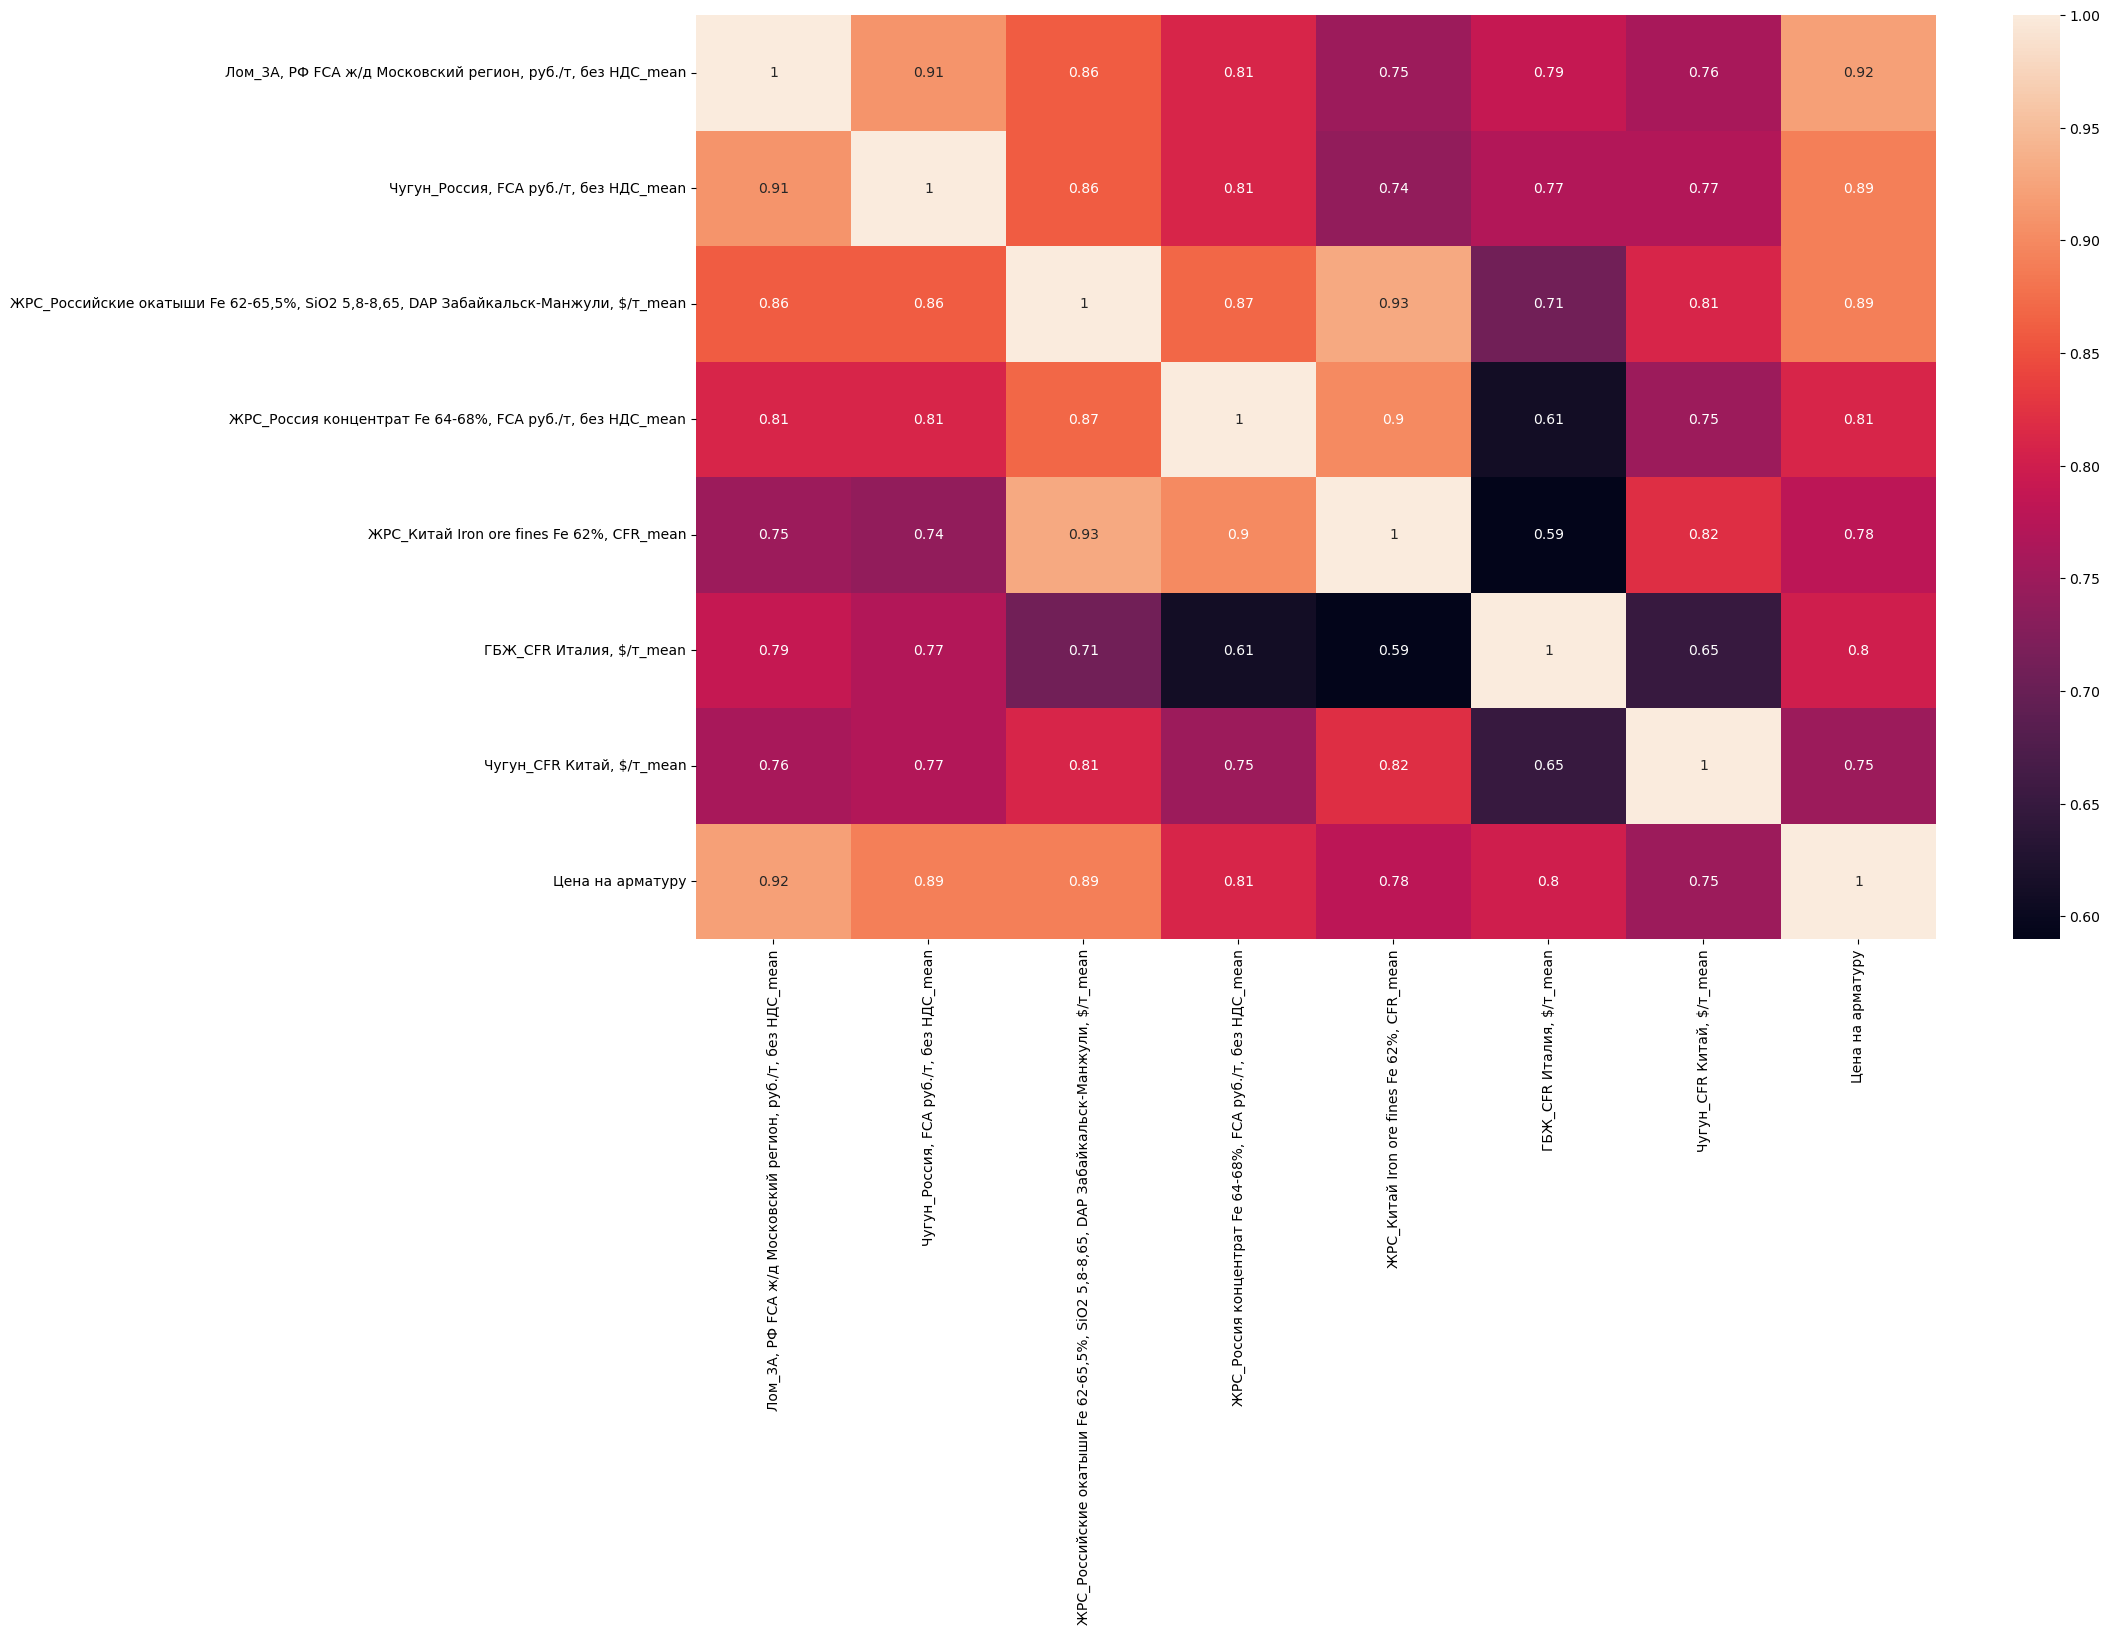

In [36]:
correlation_matrix = np.round(dtrain[corr_features].corr(),2)
fig = plt.figure(figsize=(20,12))
sns.heatmap(data=correlation_matrix, annot=True)

<Figure size 3000x1800 with 0 Axes>

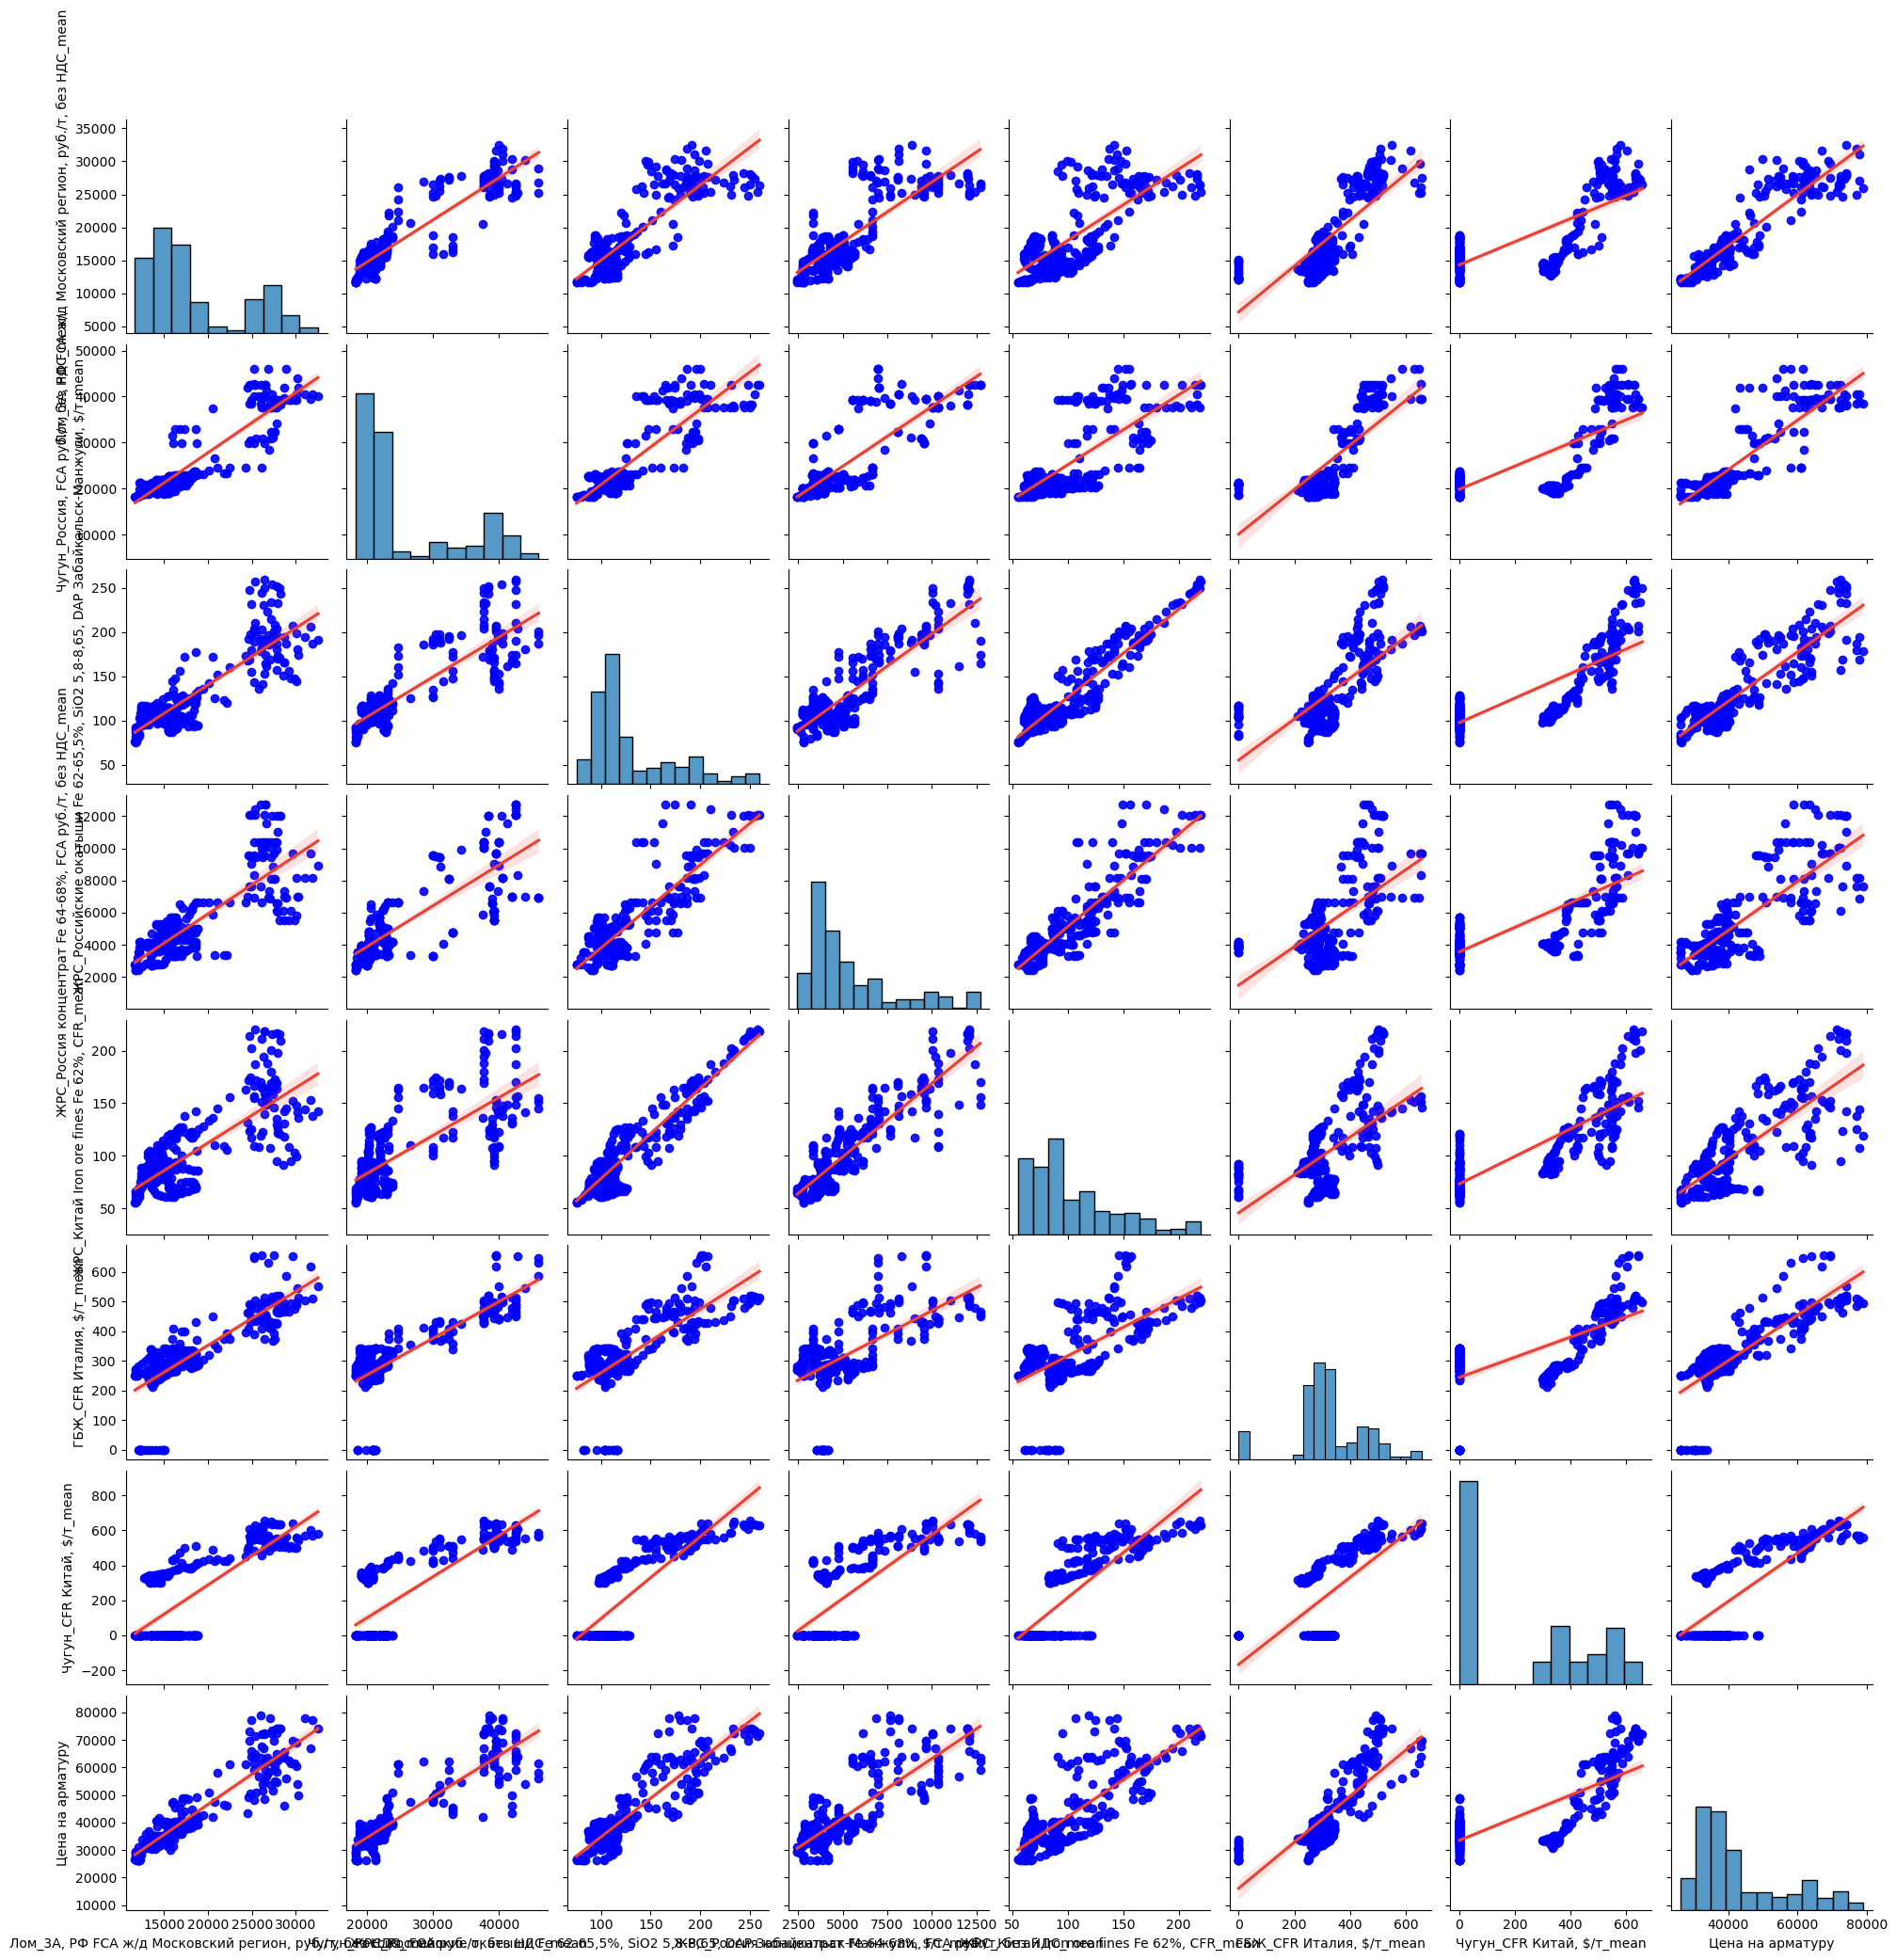

In [37]:
plt.figure(figsize=(30, 18))
sns.pairplot(
    dtrain[corr_features], 
    kind='reg', 
    diag_kind='hist', 
    plot_kws={'line_kws': {'color': '#eb4034'},
    'scatter_kws': {'alpha': 0.9,'color': 'blue'}}
)

plt.show() 

In [38]:
fit =[
    #'sin_weekday_mean',
    #'cos_weekday_mean',
    'sin_month_mean',
    'cos_month_mean',
    'sin_day_mean',
    'cos_day_mean',
    'Цена на арматуру'
]

<Figure size 3000x1800 with 0 Axes>

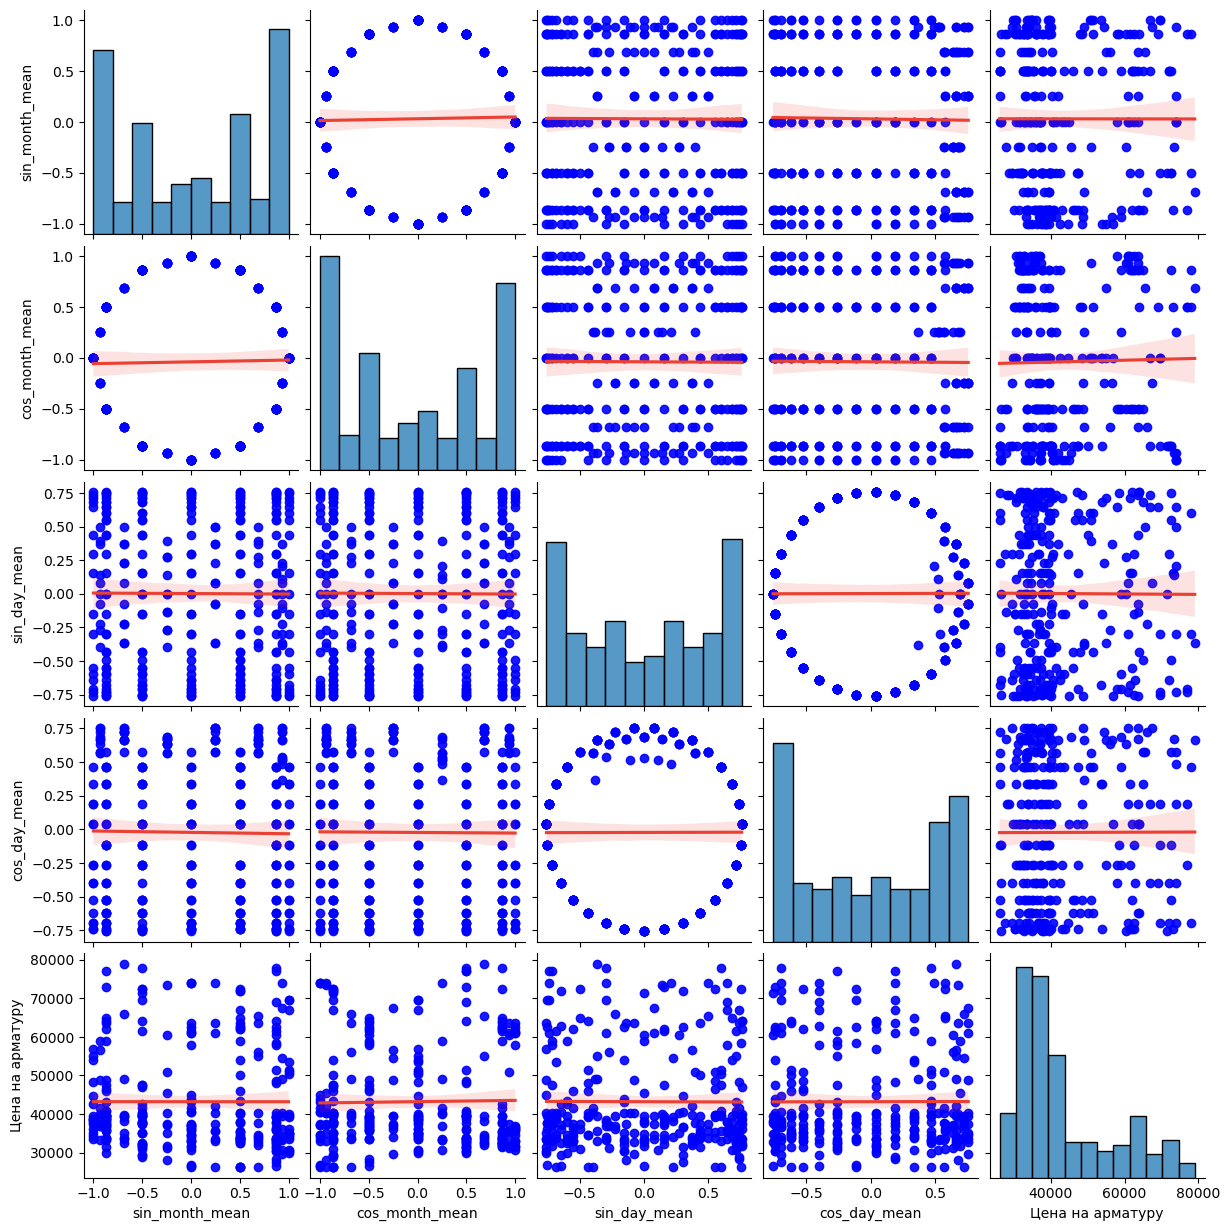

In [39]:
plt.figure(figsize=(30, 18))
sns.pairplot(
    dtrain[fit], 
    kind='reg', 
    diag_kind='hist', 
    plot_kws={'line_kws': {'color': '#eb4034'},
    'scatter_kws': {'alpha': 0.9,'color': 'blue'}}
)

plt.show()

<AxesSubplot:>

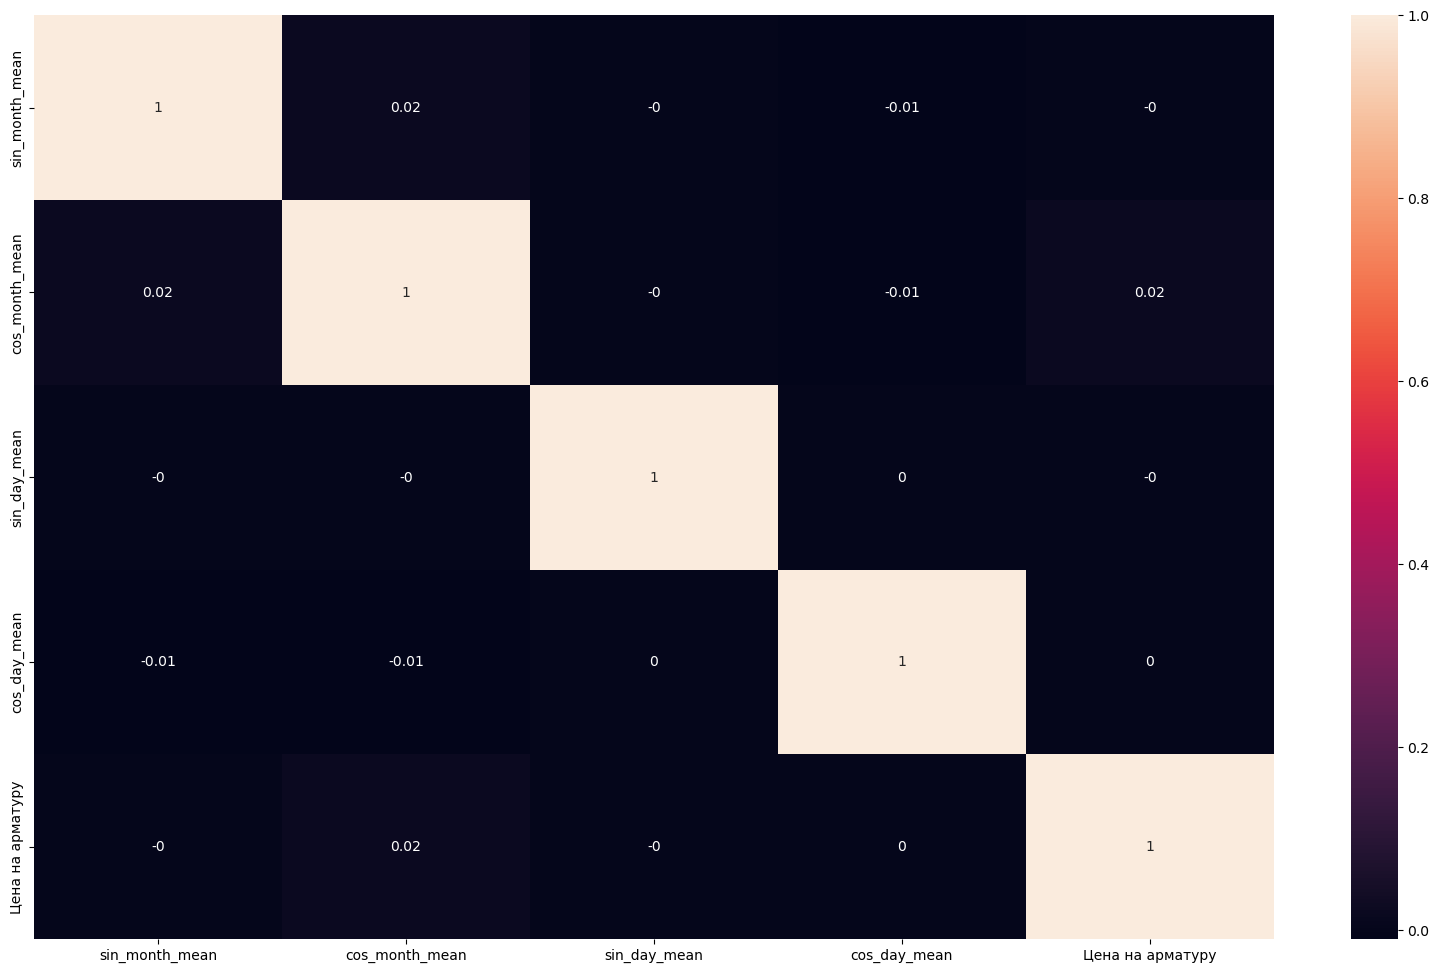

In [40]:
correlation_matrix = np.round(dtrain[fit].corr(),2)
fig = plt.figure(figsize=(20,12))
sns.heatmap(data=correlation_matrix, annot=True)

# Отбор 200 самых важных (по корреляции с целевой переменной) признаков

In [41]:


use = dtrain.corrwith(dtrain["Цена на арматуру"], numeric_only = True).abs().sort_values(ascending = False).head(200).keys().tolist()
use.remove('Цена на арматуру')
use

['Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС_sum',
 'Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС_mean',
 'Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС_min',
 'Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС_min',
 'Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС_max',
 'Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС_mean',
 'Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС_sum',
 'Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_mean',
 'Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_sum',
 'Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_min',
 'Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_max',
 'Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС_min',
 'Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС_sum',
 'Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС_mean',
 'Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС_max',
 'Лом_3А, РФ FCA ж/д респ. Татарстан, руб./т, без НДС_min',
 'Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС_sum',
 'Лом_3А

# создадим функцию с помощью которой будем обучать модель и прогнозировать на неделю вперед

In [42]:


def model_train(dtrain, dtest):
    kf = KFold(n_splits = 3, shuffle=True, random_state=0)
    predictions = []
    for i, (train_index, test_index) in enumerate(kf.split(dtrain)):
        print(f"Fold {i}:")        
   
        X_train, X_val = dtrain.loc[train_index], dtrain.loc[test_index]
    
        model = CatBoostRegressor(
            learning_rate = 0.1, 
            n_estimators = 25000
        )
        
        model.fit(
            X_train[use],
            X_train[target],
            eval_set = (X_val[use], X_val[target]),
            verbose_eval = 2000,
            early_stopping_rounds = 100)
        predictions.append(model.predict(dtest[use]))
    
    predictions = np.mean(predictions, axis=0)
    return predictions, model

# Здесь получается обучение с подкреплением прогнозируем на одну неделю. Потом данные добавляются в train

In [43]:


train_df = dtrain.copy()
test_df = dtest.copy()
target_df = pd.DataFrame()
models = []

for index, row in test_df.iterrows():
        row['predict_target'], model = model_train(train_df, row)
        train_df = train_df._append(row)
        target_df = target_df._append(row) 
        
        models.append(model)

Fold 0:
0:	learn: 11845.7168301	test: 13037.1951187	best: 13037.1951187 (0)	total: 54.6ms	remaining: 22m 43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1929.919588
bestIteration = 1105

Shrink model to first 1106 iterations.
Fold 1:
0:	learn: 12622.1225115	test: 11405.9640050	best: 11405.9640050 (0)	total: 5.58ms	remaining: 2m 19s
2000:	learn: 0.0122439	test: 2193.4806917	best: 2193.4806917 (2000)	total: 9.8s	remaining: 1m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2193.480054
bestIteration = 3182

Shrink model to first 3183 iterations.
Fold 2:
0:	learn: 12216.8785526	test: 12477.2513555	best: 12477.2513555 (0)	total: 6.16ms	remaining: 2m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2607.206998
bestIteration = 904

Shrink model to first 905 iterations.
Fold 0:
0:	learn: 11797.7939741	test: 13191.7136855	best: 13191.7136855 (0)	total: 7.52ms	remaining: 3m 7s
Stopped by overfitting detector  (100 iterations wai

Stopped by overfitting detector  (100 iterations wait)

bestTest = 1887.171235
bestIteration = 1170

Shrink model to first 1171 iterations.
Fold 0:
0:	learn: 11460.4142823	test: 13179.0560118	best: 13179.0560118 (0)	total: 7.03ms	remaining: 2m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1449.705987
bestIteration = 679

Shrink model to first 680 iterations.
Fold 1:
0:	learn: 11993.6456454	test: 12200.8931054	best: 12200.8931054 (0)	total: 6.53ms	remaining: 2m 43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2470.443875
bestIteration = 878

Shrink model to first 879 iterations.
Fold 2:
0:	learn: 12634.7385554	test: 10706.9081231	best: 10706.9081231 (0)	total: 6.25ms	remaining: 2m 36s
2000:	learn: 0.0183634	test: 2202.5349402	best: 2202.5347454 (1910)	total: 10.3s	remaining: 1m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2202.534745
bestIteration = 1910

Shrink model to first 1911 iterations.
Fold 0:
0:	learn: 111

0:	learn: 11645.3888019	test: 12362.5666749	best: 12362.5666749 (0)	total: 7.4ms	remaining: 3m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2269.017763
bestIteration = 778

Shrink model to first 779 iterations.
Fold 1:
0:	learn: 11595.8600707	test: 12456.9010088	best: 12456.9010088 (0)	total: 7.02ms	remaining: 2m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1339.548934
bestIteration = 1658

Shrink model to first 1659 iterations.
Fold 2:
0:	learn: 12306.2597428	test: 10756.5908375	best: 10756.5908375 (0)	total: 7.1ms	remaining: 2m 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2193.184577
bestIteration = 323

Shrink model to first 324 iterations.
Fold 0:
0:	learn: 11644.9803002	test: 12396.9661145	best: 12396.9661145 (0)	total: 8.83ms	remaining: 3m 40s
2000:	learn: 0.0051303	test: 1926.8602254	best: 1926.8602121 (1977)	total: 10.5s	remaining: 2m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1

In [53]:
with open('models.pkl', 'wb') as f:
    pickle.dump(models, f)
    
with open('use.pkl', 'wb') as f:
    pickle.dump(use, f)

In [45]:
target_df = target_df.set_index("dt")

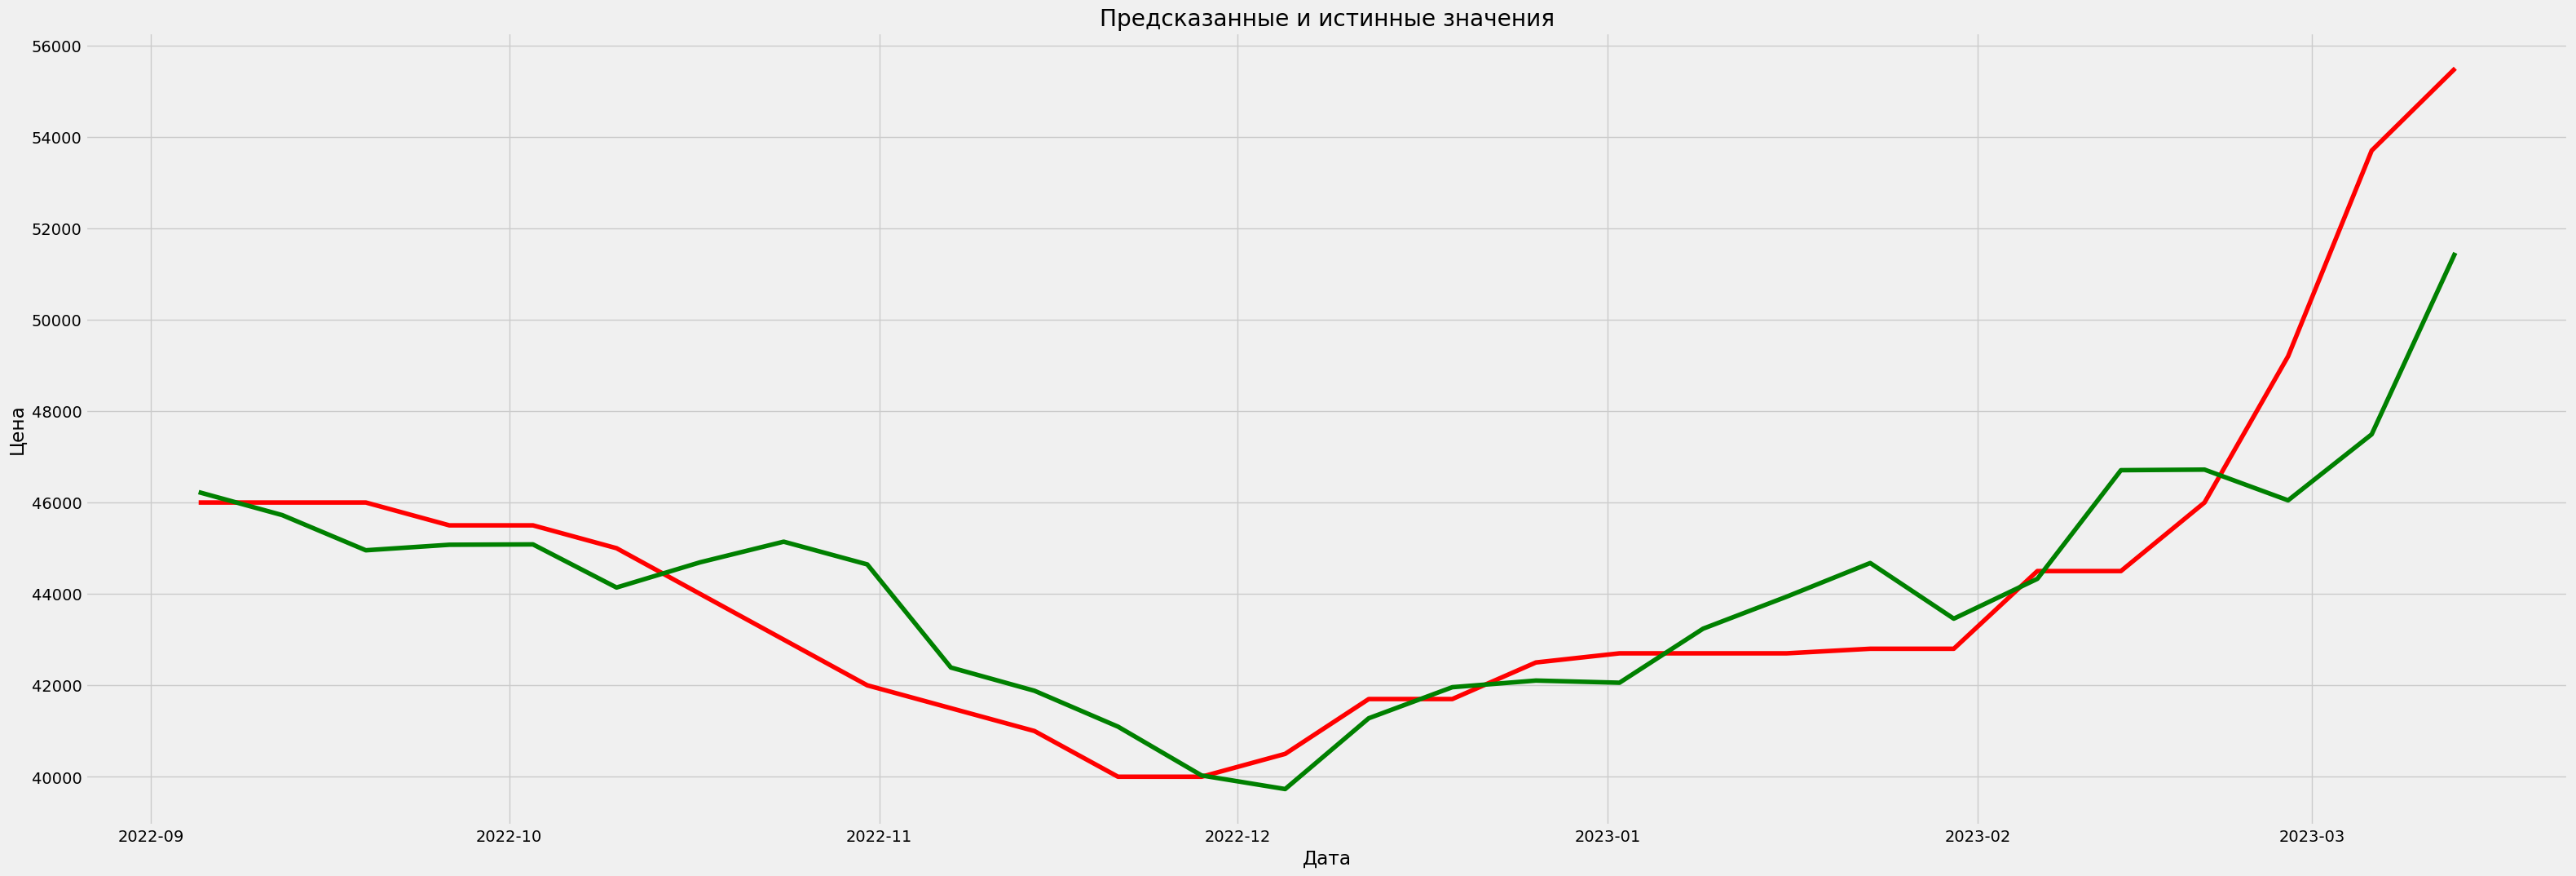

In [46]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.figure(figsize=(35, 12))
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Предсказанные и истинные значения")
 
plt.plot(target_df['Цена на арматуру'], c = 'r')
plt.plot(target_df['predict_target'], c = 'g')

In [47]:
target_df["predict_target"].min(), target_df["predict_target"].max()

(39730.32555611866, 51462.93395061077)

In [48]:
print(f'RMSE score is {np.sqrt(mean_squared_error(target_df["Цена на арматуру"], target_df["predict_target"]))}')

RMSE score is 1837.4644093547897
